In [1]:
from subprocess import check_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
#import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [2]:
df = pd.read_csv('/Users/Suki/Desktop/Zeiss/HR_comma_sep.csv')

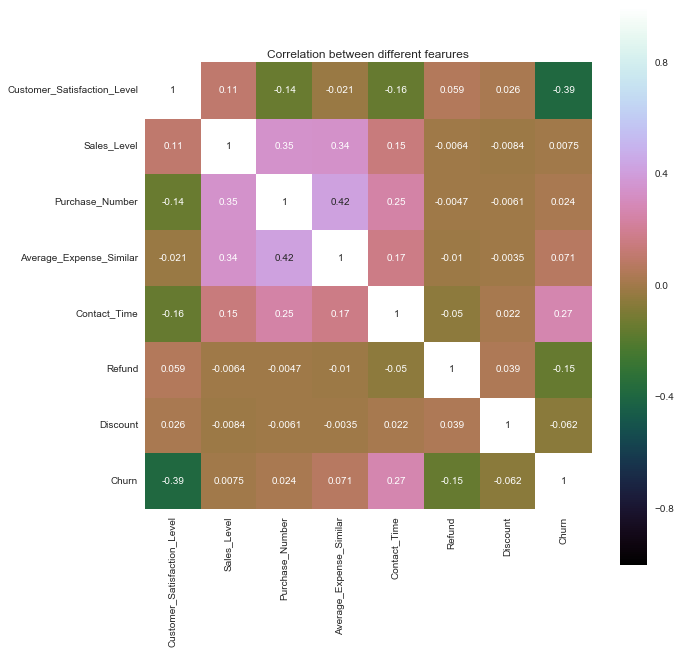

In [3]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

In [4]:
df_copy = pd.get_dummies(df)
df_copy.head()

,Customer_Satisfaction_Level,Sales_Level,Purchase_Number,Average_Expense_Similar,Contact_Time,Refund,Discount,Churn,Application_Agent,Application_Business,Application_Education,Application_Gift,Application_Hobby,Application_Others,Application_Professional,Review_high,Review_low,Review_medium
0,0.38,0.53,2,1570,2.0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.80,0.86,5,2620,4.0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.11,0.88,7,2720,2.5,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,5,2230,3.0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.37,0.52,2,1590,2.0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
df1 = df_copy
y = df1['Churn'].values
df1 = df1.drop(['Churn'],axis=1)
X = df1.values

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50)

In [7]:
log_reg = LogisticRegression()
log_reg.fit(Xtrain, ytrain)
y_val_l = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_l).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.7888


In [8]:
radm = RandomForestClassifier()
radm.fit(Xtrain, ytrain)
y_val_l = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_l).idxmax(axis=1).values
                                   == ytest)/len(ytest))
clf = radm

Validation accuracy:  0.984933333333


In [9]:
indices = np.argsort(radm.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking:')

for f in range(df1.shape[1]):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df1.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

Feature ranking:
1. feature 0 Customer_Satisfaction_Level (0.323619)
2. feature 4 Contact_Time (0.180419)
3. feature 3 Average_Expense_Similar (0.163076)
4. feature 2 Purchase_Number (0.154897)
5. feature 1 Sales_Level (0.132154)
6. feature 5 Refund (0.010020)
7. feature 15 Review_low (0.008554)
8. feature 12 Application_Others (0.004292)
9. feature 9 Application_Education (0.003923)
10. feature 10 Application_Gift (0.003512)
11. feature 14 Review_high (0.003283)
12. feature 16 Review_medium (0.002579)
13. feature 8 Application_Business (0.002569)
14. feature 11 Application_Hobby (0.002208)
15. feature 13 Application_Professional (0.001811)
16. feature 7 Application_Agent (0.001771)
17. feature 6 Discount (0.001315)


# The above shows what are the primary factors for customers to churn.

1. Customer_Satisfaction_Level
2. Contact_Time
3. Purchase_Number
4. Average_Expense_Similar
5. Sales_Level

# Predict who will churn soon

In [10]:
stay = df[df['Churn'] == 0]
stay_copy = pd.get_dummies(stay)

In [11]:
df1 = stay_copy
y = df1['Churn'].values
df1 = df1.drop(['Churn'],axis=1)
X = df1.values

In [12]:
pred = clf.predict_proba(X)

In [13]:
sum(pred[:,1]==1)

2

In [14]:
stay['will churn'] = pred[:,1]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Show who will likely to churn with probability greater than or equal to 95%

In [17]:
stay[stay['will churn']>=0.95]

,Customer_Satisfaction_Level,Sales_Level,Purchase_Number,Average_Expense_Similar,Contact_Time,Refund,Discount,Application,Review,Churn,will churn
7989,0.36,0.45,2,1350,2.0,1,0,Others,high,0,1.0
9781,0.42,0.50,2,1510,2.0,0,0,Education,low,0,1.0
